In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

path_to_git = "/Users/harshparikh/Documents/GitHub/iic_causal_inference/"

iic_burden = pd.read_pickle(
    path_to_git + "aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle"
)

iic_burden.keys()

sns.set(font_scale=4, style="whitegrid")


def plot_unit(E, D, Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig, axs = plt.subplots(
        nrows=1 + D.shape[1],
        ncols=1,
        sharex=True,
        figsize=(15, 6 + 1.25 * n_drugs),
        gridspec_kw={"height_ratios": [4] + [1 for i in range(D.shape[1])]},
    )
    axs[0].plot(E, c="black", label="Observed")
    axs[0].set_title("IIC Burden")
    for i in range(1, 1 + n_drugs):
        y = D[:, i - 1]
        axs[i].imshow(y[np.newaxis, :], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i - 1])


def setup_data(iic_burden, frame=10):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in range(n):
        try:
            E = iic_burden["Pobs"][i][:frame]
            Ename = ["iic_%d" % (j) for j in range(frame)]
            D = iic_burden["D"][i][:frame, :]
            time_of_intervention = np.argmax(D.sum(axis=1) > 0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame - 1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array(
                [
                    ["%s_%d" % (drug, j) for drug in iic_burden["Dname"]]
                    for j in range(frame)
                ]
            ).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden["Dname"][np.argmax(D[time_of_intervention, :])]
            Dname_summary = iic_burden["Dname"]
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame(
                [
                    [time_of_intervention]
                    + [First_D]
                    + list(E)
                    + [E_summary_pre, E_summary_post]
                    + list(D_flat)
                    + list(D_summary)
                ],
                index=[df.index[i]],
                columns=["time_of_intervention"]
                + ["drug_administered"]
                + Ename
                + ["avg_iic_pre", "avg_iic_post"]
                + list(Dname_flat)
                + list(Dname_summary),
            )
            #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df


def setup_coarsen_data(iic_burden, window=36, summarize="max", **kwargs):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in range(n):
        t = len(iic_burden["Pobs"][i])
        if t > window:
            if summarize == "max":
                E = np.max(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "proportion":
                threshold = kwargs.get("threshold", 0.5)
                E = np.nanmean(
                    np.array(
                        [
                            np.nanmean(iic_burden["Pobs"][i][j : j + window])
                            for j in range(t - window)
                        ]
                    )
                    > threshold
                )
            if summarize == "mean":
                E = np.mean(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "median":
                E = np.mean(
                    [
                        np.nanmedian(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )

        else:
            E = np.nanmean(iic_burden["Pobs"][i])
        E_col.append(E)
        D = np.nanmean(iic_burden["D"][i], axis=0)
        D_col.append(D)
    df["E"] = E_col
    df_D = pd.DataFrame(D_col, columns=iic_burden["Dname"], index=df.index)
    df = df.join(df_D, how="inner")
    return df

In [2]:
df_pkpd = pd.read_csv("PD_Parameters_result.csv", index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

print(df_pkpd.shape[0])

df_coarsen = setup_coarsen_data(iic_burden, window=6, summarize="max")

# df_coarsen_mean = setup_coarsen_data(iic_burden, window=6, summarize="mean")
# df_coarsen_max = setup_coarsen_data(iic_burden, window=6, summarize="max")
# df_coarsen_median = setup_coarsen_data(iic_burden, window=6, summarize="median")

print(df_coarsen.shape[0])

df_coarsen_1 = df_coarsen[
    iic_burden["Cname"]
    + [
        "mRS",
        "E",
        "lacosamide",
        "levetiracetam",
        "midazolam",
        "pentobarbital",
        "phenobarbital",
        "propofol",
        "valproate",
        "lorazepam",
        "diazepam",
        "fosphenytoin",
    ]
].dropna()

print(df_coarsen_1.shape[0])

df_coarsen_1 = df_coarsen_1.join(df_pkpd, how="inner")
print(df_coarsen_1.shape[0])

1310
1323
997
995


In [3]:
cutoff_d = (
    df_coarsen_1[
        [
            "lacosamide",
            "levetiracetam",
            "midazolam",
            "pentobarbital",
            "phenobarbital",
            "propofol",
            "valproate",
            "lorazepam",
            "diazepam",
            "fosphenytoin",
        ]
    ]
).max() / 10

In [18]:
continuous = [
    "Age",
    "iGCS-Total",
    "iGCS = T?",
    "Worst GCS in 1st 24h",
    "Worst GCS intub",
    "APACHE II 1st 24h",
    "SBP highest (1st 24h)",
    "SBP lowest (1st 24h)",
    "DBP highest (1st 24h)",
    "DBP lowest (1st 24h)",
    "HR highest (1std 24h)",
    "HR lowest (1st 24h)",
    "premorbid MRS",
]
discrete = set(iic_burden["Cname"]).difference(continuous)

df_coarsen_1["Y"] = (df_coarsen_1["mRS"] > 3).astype(float)

n_thresholds = 5
thresholds = [
    -0.000001,
    0.1,
    0.2,
    0.5,
    0.8,
    0.9,
    1.0,
]  # list(np.linspace(0,1,num=n_thresholds))
gain = 0.25
iic_level = df_coarsen_1["E"] > 2
for threshold in thresholds:
    iic_level = iic_level + (df_coarsen_1["E"] > threshold).astype(int)

drug_level = (
    (df_coarsen_1["levetiracetam"] > cutoff_d["levetiracetam"])
    + (df_coarsen_1["propofol"] > cutoff_d["propofol"])
    + (df_coarsen_1["midazolam"] > cutoff_d["midazolam"])
    + (df_coarsen_1["lacosamide"] > cutoff_d["lacosamide"])
    + (df_coarsen_1["pentobarbital"] > cutoff_d["pentobarbital"])
    + (df_coarsen_1["phenobarbital"] > cutoff_d["phenobarbital"])
    + (df_coarsen_1["diazepam"] > cutoff_d["diazepam"])
    + (df_coarsen_1["fosphenytoin"] > cutoff_d["fosphenytoin"])
    + (df_coarsen_1["valproate"] > cutoff_d["valproate"])
    + (df_coarsen_1["lorazepam"] > cutoff_d["lorazepam"])
).astype(int)

df_coarsen_1["iic"] = np.round(iic_level, 2).astype(str)
df_coarsen_1["drug"] = drug_level
df_coarsen_1["T"] = (
    "("
    + df_coarsen_1["iic"].astype(str)
    + ", "
    + df_coarsen_1["drug"].astype(str)
    + ")"
)
print(df_coarsen_1.shape[0])

df_race = pd.read_csv("covariates-full.csv", index_col=0)[["Race"]]
df_race = df_race.loc[list(df_coarsen_1.index)]
df_race = pd.get_dummies(df_race)[
    ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
]

df_coarsen_1 = df_coarsen_1.drop(
    columns=["Race_White or Caucasian", "Race_Asian", "Race_Black or African American"],
    errors="ignore",
).join(df_race, how="inner")
print(df_coarsen_1.shape[0])

# df_coarsen_1.to_csv('max_df_coarsen.csv')

995
995


In [19]:
df_coarsen_1[["Y", "T"]].groupby("T").count()

,Y
T,
"(1, 0)",57
"(1, 1)",144
"(2, 0)",20
"(2, 1)",62
"(3, 0)",52
"(3, 1)",102
"(4, 0)",39
"(4, 1)",88
"(5, 0)",24


# Effect of IIC Burden on Outcome

# Controlling for all pre-admission covariates and PKPD parameters

In [20]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[
    iic_burden["Cname"]
    + ["Race_White or Caucasian"]
    + list(df_pkpd.columns)
    + ["Y", "T"]
]
discrete = list(
    set(iic_burden["Cname"] + ["Race_White or Caucasian"]).difference(continuous)
)
m = pm.malts_mf(
    outcome="Y",
    treatment="T",
    data=df_malts_data,
    n_repeats=n_repeats,
    n_splits=n_splits,
    output_format="full",
    k_tr=3,
    k_est=5,
    discrete=discrete,
    C=0.01,
)

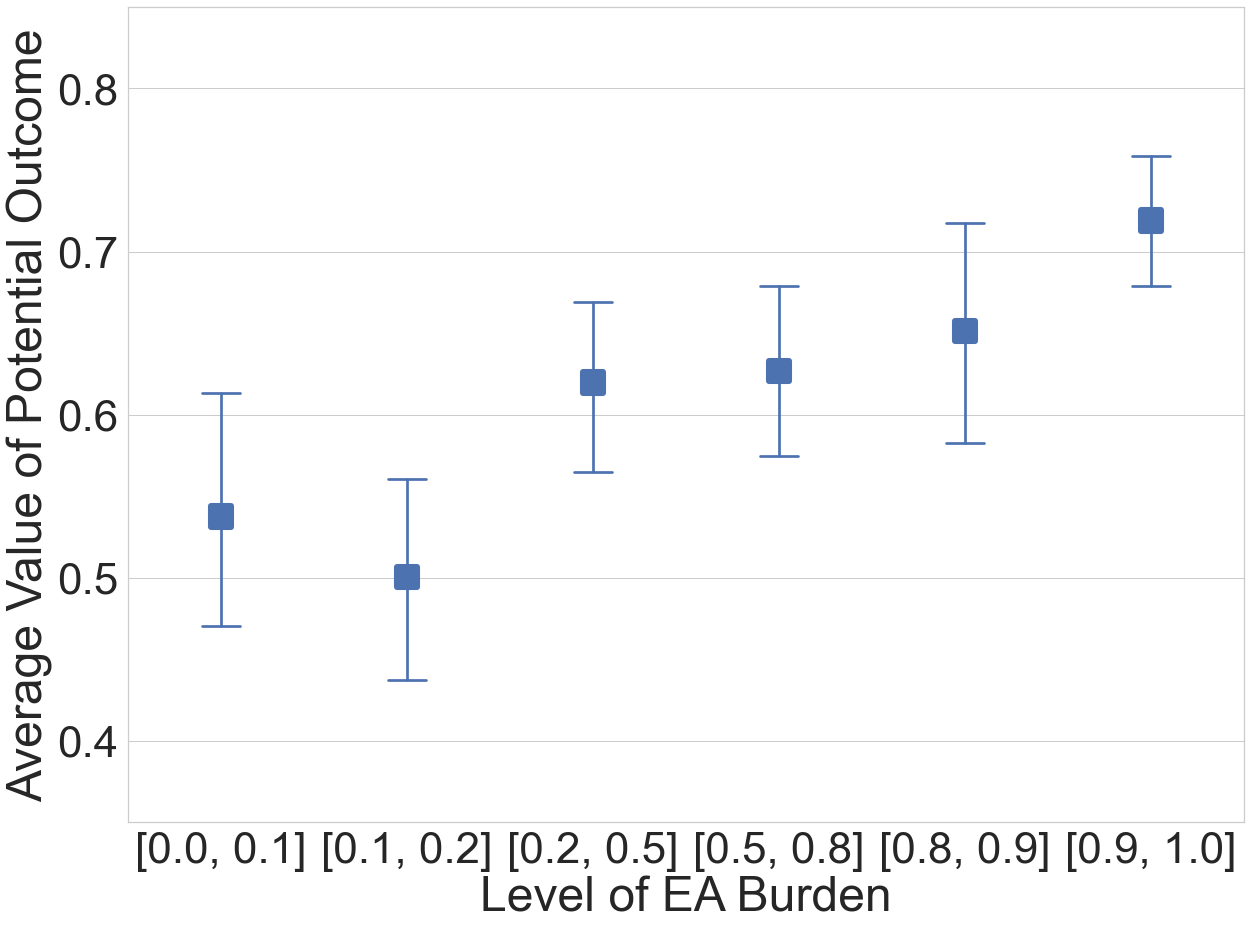

In [25]:
out = m.CATE_df.drop(columns=["Y", "T"])  # .T.groupby(level=0).mean().T
out.to_csv("new_max_c_pkpd_.csv")


columns = ["Y((" + str(i) + ", 0))" for i in range(1, len(thresholds))]
apo_0_c_pkpd = out[columns]
columns = ["Y((" + str(i) + ", 1))" for i in range(1, len(thresholds))]
apo_1_c_pkpd = out[columns]
columns = ["diameter((" + str(i) + ", 0))" for i in range(1, len(thresholds))]
diam_0_c_pkpd = out[columns]
columns = ["diameter((" + str(i) + ", 1))" for i in range(1, len(thresholds))]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(
    apo_0_c_pkpd.values * (diam_0_c_pkpd < 2000).astype(int).replace(0, np.nan).values,
    index=apo_0_c_pkpd.index,
    columns=apo_0_c_pkpd.columns,
)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(
    apo_1_c_pkpd.values * (diam_1_c_pkpd < 1000).astype(int).replace(0, np.nan).values,
    index=apo_1_c_pkpd.index,
    columns=apo_0_c_pkpd.columns,
)
apo_tight_1_c_pkpd.mean(axis=0)

fig, ax = plt.subplots(figsize=(20, 15))
sns.pointplot(
    data=apo_tight_0_c_pkpd.mean(axis=0)
    .reset_index()
    .rename(columns={0: "Average Potential Outcome"}),
    x="index",
    y="Average Potential Outcome",
    ax=ax,
    join=False,
    capsize=0.2,
    markers=["s"],
    scale=3,
    ci=95,
)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel("Level of EA Burden")
plt.ylabel("Average Value of Potential Outcome")
plt.ylim((0.35, 0.85))
plt.xticks(
    np.arange(len(thresholds) - 1),
    [
        str([np.abs(np.round(thresholds[i - 1], 2)), thresholds[i]])
        for i in range(1, len(thresholds))
    ],
)


# plt.title("Controlling for Preadmission\n Covariates and Pharmacodynamics")
fig.savefig("new_max_c_pkpd.png")

In [295]:
(apo_tight_0_c_pkpd.groupby("index").mean() - 0.531029) * 100 / 0.531029

,Average Potential Outcome
index,
"Y((0.12, 0))",0.000020
"Y((0.38, 0))",8.028429
"Y((0.62, 0))",18.606690
"Y((0.88, 0))",22.276672


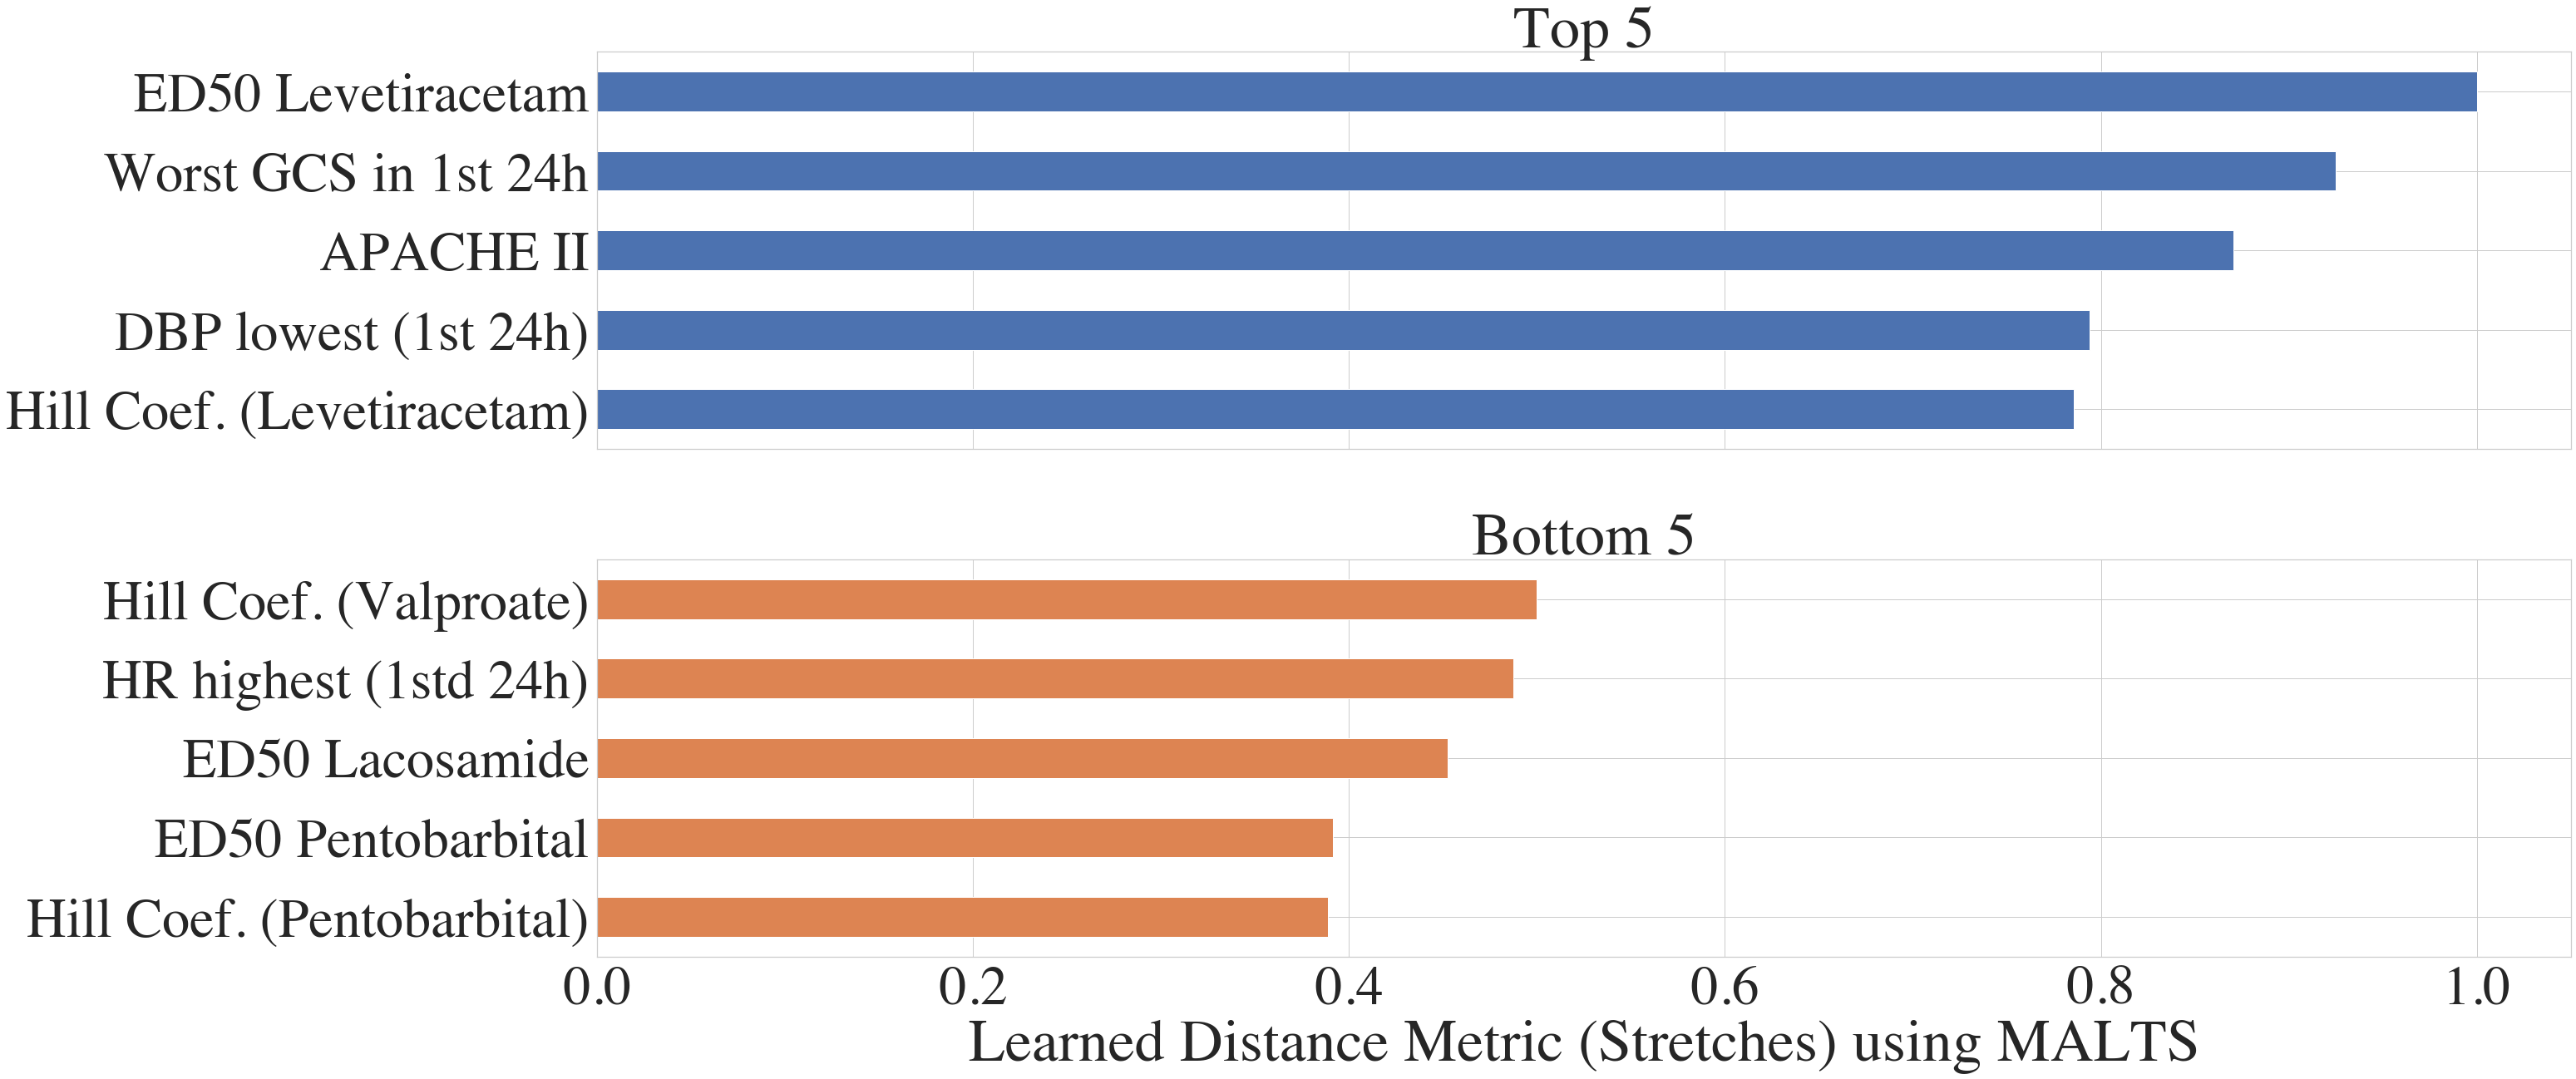

In [151]:
sns.set(font_scale=6, style="whitegrid")
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=False)
fig, ax = plt.subplots(figsize=(45, 20), nrows=2, sharex=True)
pd.concat(m.M_opt_list).to_csv("M_opt_max.csv")
M_opt = pd.read_csv("M_opt_max.csv", index_col=0).drop(
    columns=["iGCS-Total", "iGCS = T?", "Worst GCS intub",]
)
columns_order = list(M_opt.mean(axis=0).sort_values(ascending=False).index)
M_opt = M_opt / M_opt[columns_order[0]].mean()
columns_to_include_top = columns_order[:5][
    ::-1
]  # ['iGCS-Total','Age','APACHE II 1st 24h','SBP highest (1st 24h)','Hx PVD','propofol_50'][::-1]
columns_to_include_bottom = columns_order[-5:][::-1]
# pd.concat(m.M_opt_list)[columns_order].plot(kind='box',ax=ax,rot=90,showmeans=True)
# M_opt[columns_to_include].std(axis=0)/2
# plt.ylim(-0.001,1.0)
M_opt[columns_to_include_top].mean(axis=0).rename(
    index={
        "propofol_50": "Propofol50",
        "levetiracetam_50": "ED50 Levetiracetam",
        "levetiracetam_Hill": "Hill Coef. (Levetiracetam)",
        "Hx PVD": "Hx Peripheral Vascular Disease",
        "SBP highest (1st 24h)": "Highest Systolic BP (1st 24h)",
        "APACHE II 1st 24h": "APACHE II",
        "iGCS-Total": "Initial Glasgow Coma Scale",
    }
).plot(kind="barh", ax=ax[0], color="C0")
ax[0].set_title("Top 5")
# ax[0].set_xticks([1,2,3,4,5],['Initial Glasgow Comma Score','Age','APACHE II Score','Systolic Blood Pressure','Peripheral vascular disease','Propofol50'])
M_opt[columns_to_include_bottom].mean(axis=0).rename(
    index={
        "Marrital": "Marital Status",
        "Hx DM": "Hx Diabetes Mellitus",
        "lacosamide_Hill": "Lacosamide Hill Coef.",
        "pentobarbital_Hill": "Hill Coef. (Pentobarbital)",
        "lacosamide_50": "ED50 Lacosamide",
        "pentobarbital_50": "ED50 Pentobarbital",
        "valproate_Hill": "Hill Coef. (Valproate)",
    }
).plot(kind="barh", ax=ax[1], color="C1")
ax[1].set_title("Bottom 5")
plt.subplots_adjust(wspace=0.005, hspace=0.1)
plt.xlabel("Learned Distance Metric (Stretches) using MALTS")
plt.tight_layout()
plt.savefig("max_stretchplot.png")

In [153]:
pd.concat(m.M_opt_list).mean(axis=0).to_csv("MALTS_distmat.csv")

In [155]:
apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(
    columns={0: "Average Potential Outcome"}
).dropna().to_csv("average_te_c_pkpd.csv")

In [157]:
out_age = pd.read_csv("new_max_age.csv", index_col=0)
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in thresholds[1:]
]
apo_0_age = out_age[columns]
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in thresholds[1:]
]
apo_1_age = out_age[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in thresholds[1:]
]
diam_0_age = out_age[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in thresholds[1:]
]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(
    apo_0_age.values * (diam_0_age < 10).astype(int).replace(0, np.nan).values,
    index=apo_0_age.index,
    columns=apo_0_age.columns,
)


out_c = pd.read_csv("new_max_c.csv", index_col=0)
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
apo_0_c = out_c[columns]
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
apo_1_c = out_c[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
diam_0_c = out_c[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(
    apo_0_c.values * (diam_0_c < 700).astype(int).replace(0, np.nan).values,
    index=apo_0_c.index,
    columns=apo_0_c.columns,
)


out = pd.read_csv("new_max_c_pkpd.csv", index_col=0)
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
apo_0_c_pkpd = out[columns]
columns = [
    "Y((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
apo_1_c_pkpd = out[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 0))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
diam_0_c_pkpd = out[columns]
columns = [
    "diameter((" + str(np.round(threshold - gain / 2, 2)) + ", 1))"
    for threshold in np.linspace(thresholds[1], 1, num=n_thresholds - 1)
]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(
    apo_0_c_pkpd.values * (diam_0_c_pkpd < 2000).astype(int).replace(0, np.nan).values,
    index=apo_0_c_pkpd.index,
    columns=apo_0_c_pkpd.columns,
)

In [159]:
apo_tight_0_age = pd.read_csv("average_te_max_age.csv", index_col=0)
apo_tight_0_c = pd.read_csv("average_te_max_c.csv", index_col=0)
apo_tight_0_c_pkpd = pd.read_csv("average_te_c_pkpd.csv", index_col=0)

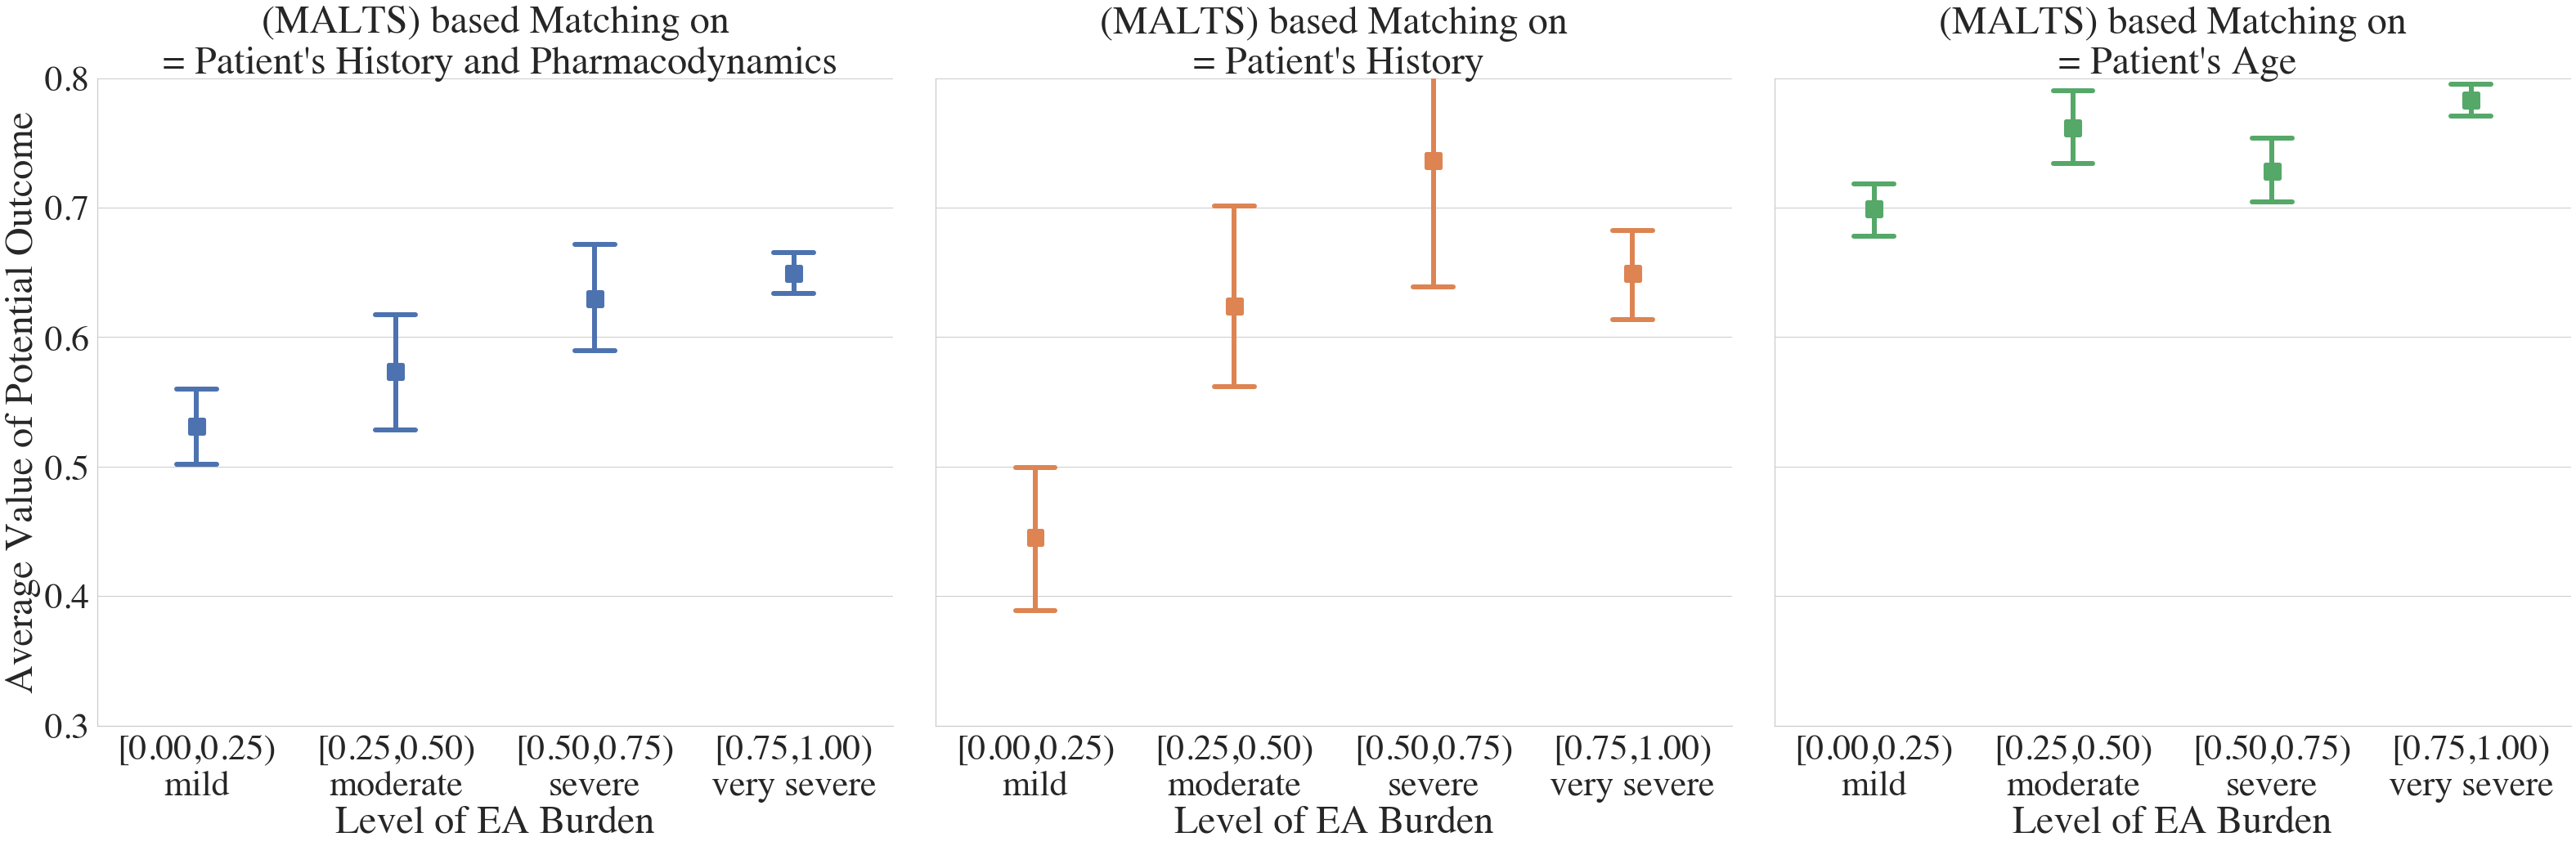

In [289]:
sns.set(font_scale=4, style="whitegrid")
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=False)

# fig,ax = plt.subplots(figsize=(20,15))
control = [
    "Patient's History and Pharmacodynamics",
    "Patient's History",
    "Patient's Age",
]
df_apo = [apo_tight_0_c_pkpd, apo_tight_0_c, apo_tight_0_age]
df_plot = pd.DataFrame()
for i in range(len(df_apo)):
    df_plot_ = df_apo[i]
    df_plot_["(MALTS) based Matching on\n"] = [
        control[i] for k in range(df_plot_.shape[0])
    ]
    df_plot = df_plot.append(df_plot_)

g = sns.FacetGrid(
    df_plot,
    col="(MALTS) based Matching on\n",
    hue="(MALTS) based Matching on\n",
    height=15,
    sharex=True,
    sharey=True,
)
g.map(
    sns.pointplot,
    "index",
    "Average Potential Outcome",
    join=False,
    capsize=0.2,
    markers=["s", "o", "v"],
    dodge=0.25,
    scale=2.5,
    errwidth=6,
    ci=90,
)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
# plt.axhline(0.528,c='black',ls='--',lw=5)
g.set_xlabels("Level of EA Burden")
g.set_ylabels("Average Value of Potential Outcome")
plt.ylim((0.3, 0.8))
level_eng = ["mild", "moderate", "severe", "very severe"]
plt.xticks(
    np.arange(len(thresholds) - 1),
    [
        "[%.2f,%.2f)\n%s" % (np.abs(thresholds[i - 1]), thresholds[i], level_eng[i - 1])
        for i in range(1, len(thresholds))
    ],
)
# plt.legend([],[], frameon=False)
plt.savefig("comp_max_.png")

# Comparing to Prediction Model

In [290]:
df_logistic = df_coarsen_1[iic_burden["Cname"] + ["Y", "iic", "drug"]]
df_logistic = pd.get_dummies(
    df_logistic[iic_burden["Cname"] + ["iic", "drug", "Y"]], columns=["iic"]
)
prognostic_model = lm.LogisticRegressionCV().fit(
    df_logistic.drop(columns=["Y"]), df_logistic["Y"],
)

In [291]:
df_logistic_pred = df_logistic.copy(deep=True)
logit_reg_te = pd.DataFrame()

iic_cols = [col for col in list(df_logistic.columns) if "iic" in col]

for col in iic_cols:
    for col2 in iic_cols:
        df_logistic_pred[col2] = 0
    df_logistic_pred[col] = 1
    df_logistic_pred["drug"] = 0
    logit_reg_te_temp = pd.DataFrame()
    logit_reg_te_temp["Potential Outcome"] = [
        np.mean(
            prognostic_model.predict_proba(
                df_logistic_pred.drop(columns=["Y"]).sample(frac=0.8, replace=True)
            )[:, 1]
        )
        for repeat in range(10)
    ]
    logit_reg_te_temp["iic"] = [col for repeat in range(10)]
    logit_reg_te = logit_reg_te.append(logit_reg_te_temp, ignore_index=True)

# Matched Group Analysis

In [211]:
MG = m.MG_matrix
MG_b = (MG > 12).astype(int)
MG_b = MG_b.loc[MG_b.sum(axis=1) > 0]
MG_b = MG_b[list(MG_b.index)]
MG.to_csv("matched_group_matrix.csv")

In [212]:
tight_mg_idx = list(diam_0_c_pkpd.max(axis=1).sort_values().index[:6])
for idx in tight_mg_idx:
    MG_i = MG_b.loc[idx]
    print(df_malts_data.loc[MG_i.loc[MG_i > 0].index].shape)
    df_malts_data.loc[MG_i.loc[MG_i > 0].index].to_csv("mg_%s.csv" % (idx))

(6, 90)
(11, 90)
(12, 90)
(8, 90)
(10, 90)
(11, 90)


In [209]:
MG_i

sid3       0
sid4       0
sid5       0
sid7       0
sid8       0
          ..
sid1986    0
sid1989    0
sid1990    0
sid1991    0
sid1999    0
Name: sid268, Length: 995, dtype: int64

In [193]:
G = nx.from_pandas_adjacency(MG_b)

# Heterogeneous Effect

In [213]:
out = pd.read_csv("new_max_c_pkpd.csv", index_col=0)

In [214]:
y_u = out[[i for i in out.columns if "Y((0.88, 1))" in i]].mean(axis=1)
y_l = out[[i for i in out.columns if "Y((0.12, 1))" in i]].mean(axis=1)
te = y_u - y_l

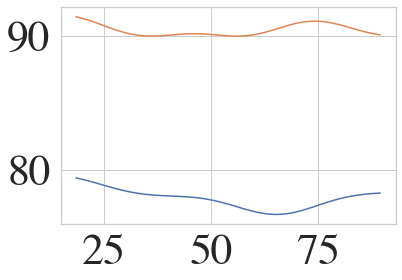

In [215]:
import sklearn.ensemble as en

m_age_l = svm.SVR().fit(df_coarsen_1[["Age"]], 100 * y_l)
m_age_u = svm.SVR().fit(df_coarsen_1[["Age"]], 100 * y_u)
age_range = np.arange(np.min(df_coarsen_1["Age"]), np.max(df_coarsen_1["Age"]) + 1)
risk_age_l = m_age_l.predict(age_range.reshape(-1, 1))
risk_age_u = m_age_u.predict(age_range.reshape(-1, 1))
plt.plot(age_range, risk_age_l)
plt.plot(age_range, risk_age_u)

In [267]:
# cols = iic_burden['Cname']
hetero_te_m = {}
cols = [
    "NeuroDx:IschStroke",
    "NeuroDx:HemStroke",
    "NeuroDx:Brain tumor",
    "NeuroDx:CNS infection",
    "NeuroDx:HIE/ABI",
    "NeuroDx:TME",
    "NeuroDx:Degenerative",
    "NeuroDx:Spells",
    "Gender",
]
for col in cols:
    hetero_te_m[col] = tree.DecisionTreeRegressor(
        max_depth=4, max_leaf_nodes=8, min_samples_leaf=10
    ).fit(df_coarsen_1[[col]], 100 * (y_u - y_l) / y_l)

hetero_te_m["all"] = tree.DecisionTreeRegressor(
    max_depth=3, max_leaf_nodes=8, min_samples_leaf=70
).fit(df_coarsen_1[cols], 100 * (y_u - y_l) / y_l)

In [268]:
df_cns = df_coarsen_1[cols]
df_cns["Relative EA Effect"] = 100 * (y_u - y_l) / y_l

In [270]:
cols2 = [
    # "NeuroDx:IschStroke",
    # "NeuroDx:HemStroke",
    "NeuroDx:Brain tumor",
    "NeuroDx:CNS infection",
    # "NeuroDx:HIE/ABI",
    # "NeuroDx:TME",
    # "NeuroDx:Degenerative"
]
df_cns.groupby(cols2).mean().join(
    1.96 * df_cns.groupby(cols2).sem(), rsuffix=" CI Width",
).join(df_cns.groupby(cols2).count(), rsuffix=" Num. of Patients")[
    [
        "Relative EA Effect",
        "Relative EA Effect CI Width",
        "Relative EA Effect Num. of Patients",
    ]
].round(
    2
)

Relative EA Effect  \
NeuroDx:Brain tumor NeuroDx:CNS infection                       
0.0                 0.0                                 19.28   
                    1.0                                 22.82   
1.0                 0.0                                 17.16   
                    1.0                                  8.19   

                                           Relative EA Effect CI Width  \
NeuroDx:Brain tumor NeuroDx:CNS infection                                
0.0                 0.0                                           1.58   
                    1.0                                           6.89   
1.0                 0.0                                           4.22   
                    1.0                                          12.92   

                                           Relative EA Effect Num. of Patients  
NeuroDx:Brain tumor NeuroDx:CNS infection                                       
0.0                 0.0                                                    824  
                    1.0                                                     58  
1.0                 0.0                                                    107  
                    1.0                                                      6

In [288]:
def compose(cols2):
    df_composed = (
        df_cns.groupby(cols2)
        .mean()
        .join(1.96 * df_cns.groupby(cols2).sem(), rsuffix=" CI Width",)
        .join(df_cns.groupby(cols2).count(), rsuffix=" Num. of Patients")[
            [
                "Relative EA Effect",
                "Relative EA Effect CI Width",
                "Relative EA Effect Num. of Patients",
            ]
        ]
        .round(2)
    )
    df_composed["Covariate"] = [cols2 for i in range(df_composed.shape[0])]
    return df_composed


pd.concat([compose(cols2) for cols2 in cols], axis=0,).reset_index().set_index(
    ["Covariate", "index"]
)

Relative EA Effect  Relative EA Effect CI Width  \
Covariate             index                                                    
NeuroDx:IschStroke    0.0                 19.35                         1.51   
                      1.0                 17.49                         4.85   
NeuroDx:HemStroke     0.0                 19.81                         1.59   
                      1.0                 16.03                         3.36   
NeuroDx:Brain tumor   0.0                 19.52                         1.54   
                      1.0                 16.68                         4.06   
NeuroDx:CNS infection 0.0                 19.04                         1.48   
                      1.0                 21.45                         6.43   
NeuroDx:HIE/ABI       0.0                 18.63                         1.48   
                      1.0                 26.46                         5.80   
NeuroDx:TME           0.0                 19.44                         1.53   
                      1.0                 17.11                         4.24   
NeuroDx:Degenerative  0.0                 19.12                         1.46   
                      1.0                 21.17                         9.60   
NeuroDx:Spells        0.0                 19.17                         1.45   
                      1.0                 23.90                        22.29   
Gender                0.0                 18.65                         1.91   
                      1.0                 19.80                         2.18   

                             Relative EA Effect Num. of Patients  
Covariate             index                                       
NeuroDx:IschStroke    0.0                                    910  
                      1.0                                     85  
NeuroDx:HemStroke     0.0                                    832  
                      1.0                                    163  
NeuroDx:Brain tumor   0.0                                    882  
                      1.0                                    113  
NeuroDx:CNS infection 0.0                                    931  
                      1.0                                     64  
NeuroDx:HIE/ABI       0.0                                    923  
                      1.0                                     72  
NeuroDx:TME           0.0                                    891  
                      1.0                                    104  
NeuroDx:Degenerative  0.0                                    960  
                      1.0                                     35  
NeuroDx:Spells        0.0                                    990  
                      1.0                                      5  
Gender                0.0                                    520  
                      1.0                                    475

[Text(372.0, 475.65000000000003, 'NeuroDx:HemStroke <= 0.5\nmse = 539.095\nsamples = 995\nvalue = 19.195'),
 Text(279.0, 339.75, 'NeuroDx:IschStroke <= 0.5\nmse = 564.354\nsamples = 832\nvalue = 19.594'),
 Text(186.0, 203.85000000000002, 'NeuroDx:TME <= 0.5\nmse = 575.645\nsamples = 760\nvalue = 19.836'),
 Text(93.0, 67.94999999999999, 'mse = 583.844\nsamples = 665\nvalue = 19.935'),
 Text(279.0, 67.94999999999999, 'mse = 517.696\nsamples = 95\nvalue = 19.139'),
 Text(372.0, 203.85000000000002, 'mse = 438.035\nsamples = 72\nvalue = 17.041'),
 Text(465.0, 339.75, 'mse = 405.199\nsamples = 163\nvalue = 17.156')]

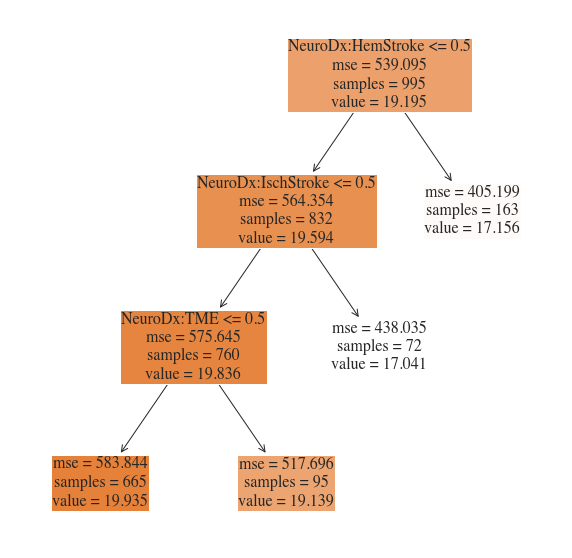

In [227]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(hetero_te_m["all"], feature_names=cols, filled=True, ax=ax)

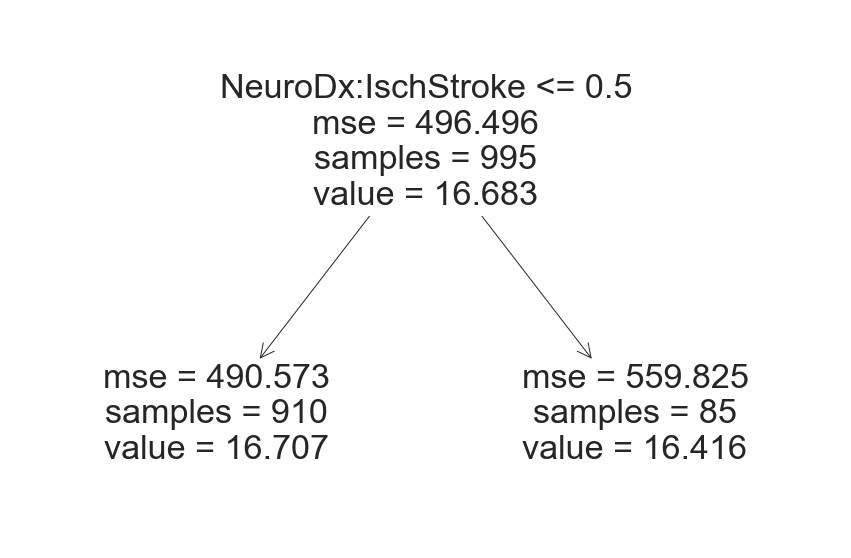

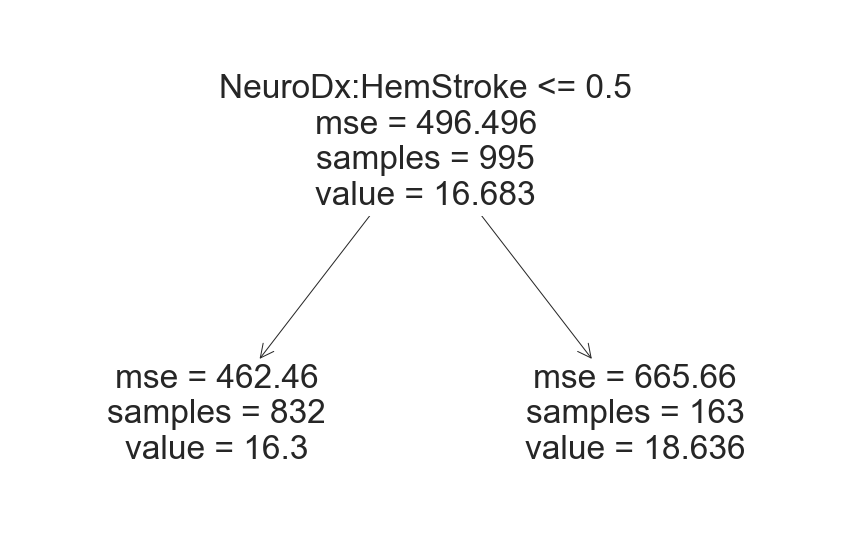

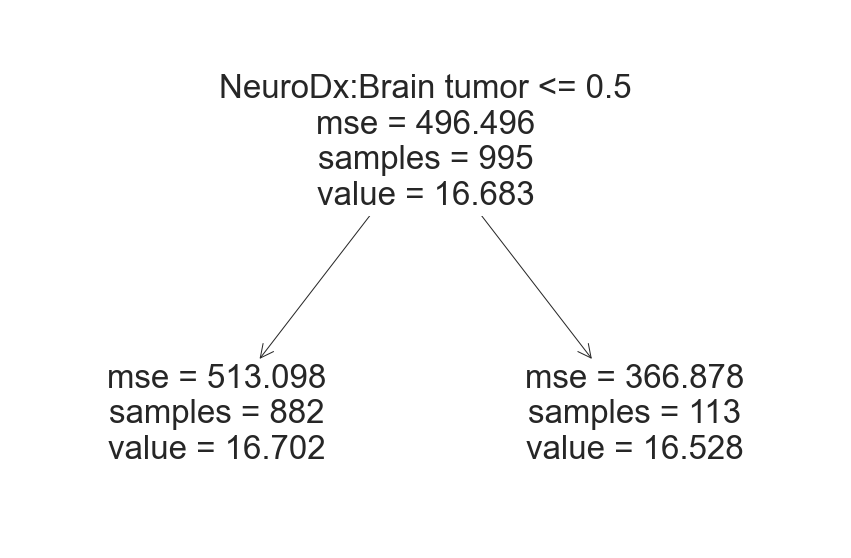

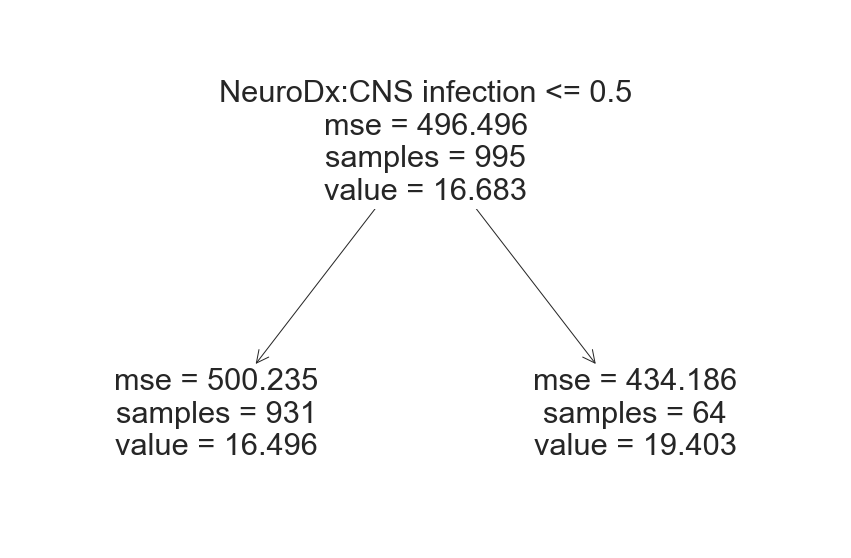

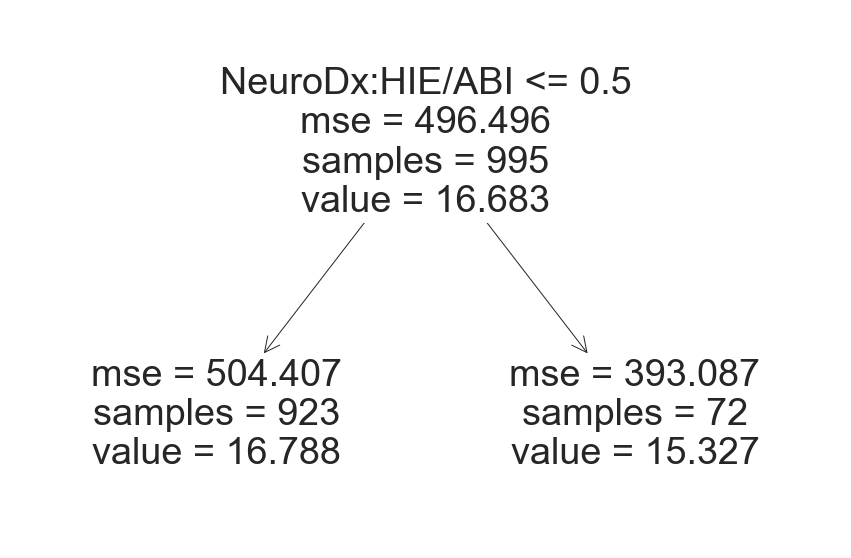

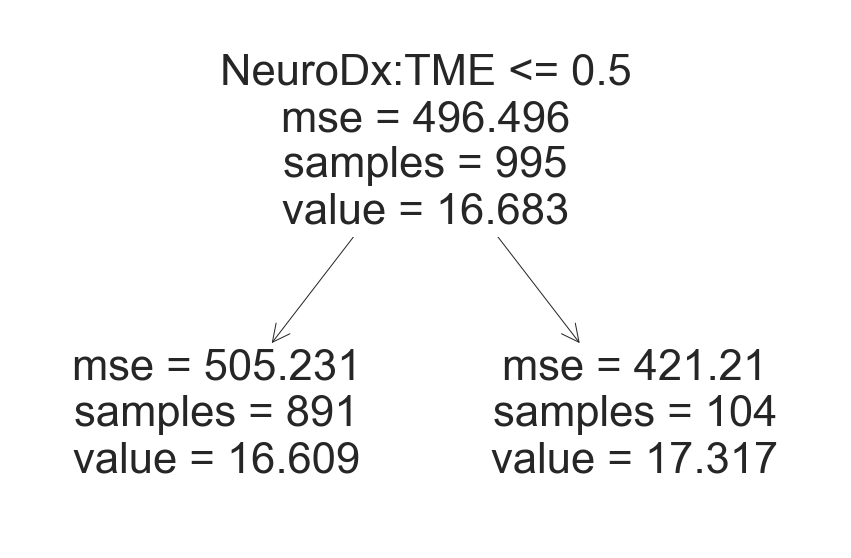

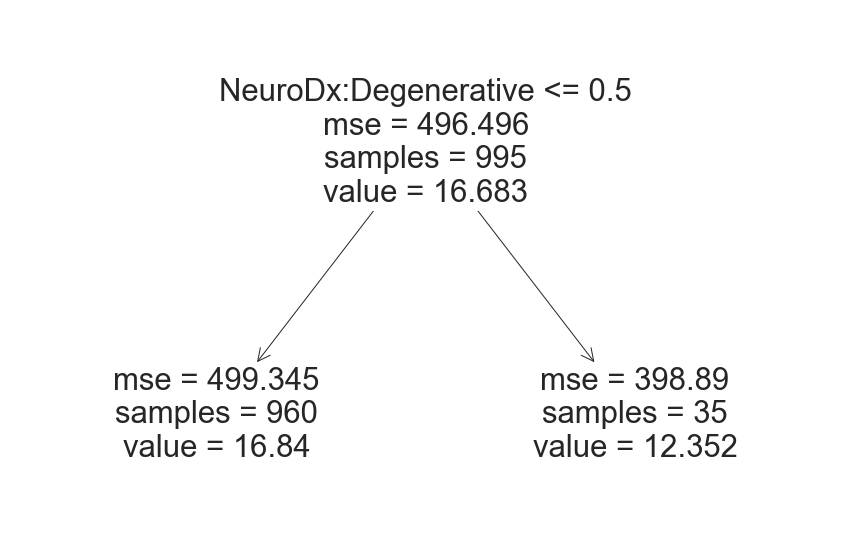

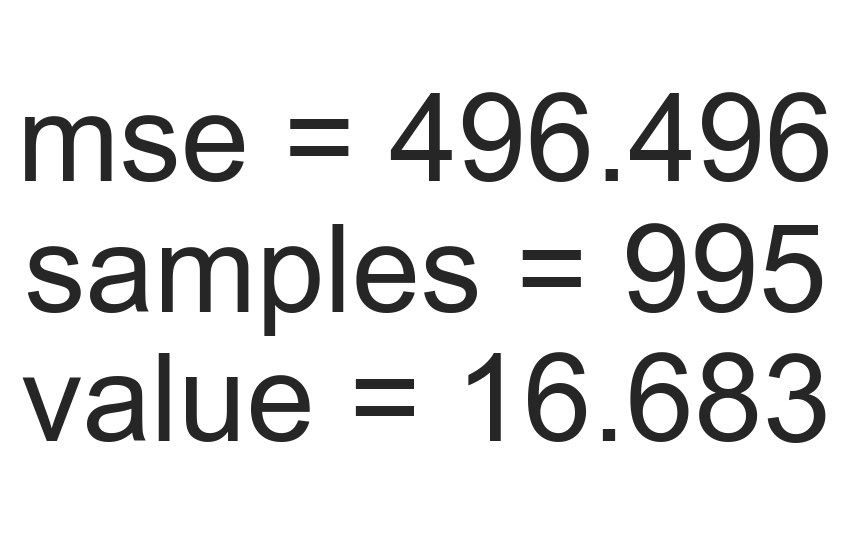

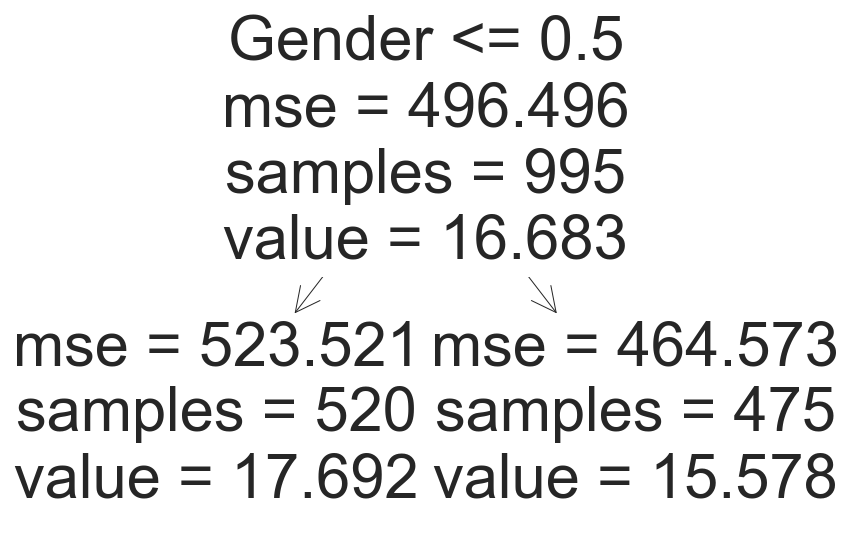

In [21]:
for col in cols:
    fig,ax = plt.subplots(figsize=(15,10))
    tree.plot_tree(hetero_te_m[col],feature_names=[col],filled=False)
    fig.savefig('hetero_tree_%s.png'%(col.replace('/','_').replace(':','_')))

In [122]:
df_apo_pkpd_c = cate_df[list(filter( lambda x: 'Y(' in x, cate_df.columns ))].T.reset_index().groupby(by='index').mean().T
df_apo_pkpd_c.to_csv('potential_outcome_pkpd_c.csv')

# Logistic Regression

In [33]:
malts_res = pd.read_csv('average_te_c_pkpd.csv',index_col=0)

In [28]:
data_lr = df_coarsen_1.drop(columns=['T','E']).astype(float)
data_lr['iic'] = ((data_lr['iic'].astype(float)*10).astype(int) - 1)//2

In [31]:
lr_model = lm.LogisticRegressionCV().fit(data_lr.drop(columns=['Y']),data_lr['Y'])

In [32]:
est_lr = pd.DataFrame()
for repeat in range(10):
    data_bootstrap = data_lr.sample(replace=True,frac=2/3)
    lr_model = lm.LogisticRegressionCV().fit(data_bootstrap.drop(columns=['Y']),data_bootstrap['Y'])
    est_lr_ = pd.DataFrame()
    for iic_b in [0,1,2,3]:
#         data_bootstrap['iic'] = iic_b
#         data_bootstrap['drug'] = 0
        est_lr_[iic_b] = [np.mean(lr_model.predict_proba(data_bootstrap.loc[(data_bootstrap['iic']==iic_b) & (data_bootstrap['drug']==0)].drop(columns=['Y']))[:,1])]
    est_lr_ = est_lr_.T
    est_lr = est_lr.append(est_lr_)


In [60]:
est_naive = pd.DataFrame()
data_naive = df_coarsen_1.drop(columns=['T','E']).astype(float)
data_naive['iic'] = ((data_naive['iic'].astype(float)*10).astype(int) - 1)//2
for repeat in range(10):
    data_bootstrap = data_naive.sample(replace=True,frac=2/3)
    est_naive_ = pd.DataFrame()
    for iic_b in [0,1,2,3]:
        data_bootstrap_iic = data_bootstrap.loc[(data_bootstrap['iic']==iic_b) & (data_bootstrap['drug']==0)]
        est_naive_[iic_b] = [np.nanmean(data_bootstrap_iic['Y'])]
    est_naive_ = est_naive_.T
    est_naive = est_naive.append(est_naive_)

In [78]:
propensity_model = lm.LogisticRegressionCV().fit(data_lr.drop(columns=['Y','iic']),data_lr['iic'])
est_pm = pd.DataFrame()
ates = []
for repeat in tqdm.tqdm(range(10)):
    data_bootstrap = data_lr.sample(replace=True,frac=2/3)
    propensity_model = lm.LogisticRegressionCV().fit(data_bootstrap.drop(columns=['Y','iic']),data_bootstrap[['iic','drug']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
))
    pscore = propensity_model.predict_proba(data_bootstrap.drop(columns=['Y','iic']))
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(pscore)
    distances, indices = nbrs.kneighbors(pscore)
    cates = pd.DataFrame()
    for j in range(indices.shape[0]):
        mg_prop = data_bootstrap[['Y','iic','drug']].iloc[indices[j,:]]
        mg_prop_0 = mg_prop.loc[mg_prop['drug']<0.5].drop(columns=['drug'])
        est_prop_j = mg_prop_0.groupby(by='iic').mean().T
        cates = cates.append(est_prop_j,ignore_index=True)
    ate = cates.mean(axis=0)
    ates.append(ate)
est_prop = pd.concat(ates)

100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


In [80]:
pscore

array([[3.30662484e-01, 6.33186820e-03, 2.03079257e-01, ...,
        5.84718182e-03, 4.32767254e-01, 4.20347575e-03],
       [1.19584335e-01, 3.94056235e-02, 5.20963436e-01, ...,
        1.41142383e-01, 3.45497167e-02, 1.41434963e-01],
       [1.01305802e-02, 2.78231066e-01, 4.96642716e-05, ...,
        8.30418726e-02, 1.68561782e-02, 4.44481285e-01],
       ...,
       [3.40491771e-14, 6.42118897e-02, 1.35798680e-15, ...,
        2.99700220e-02, 8.96112304e-14, 8.91698733e-01],
       [9.37453884e-15, 5.08477395e-01, 2.45285295e-12, ...,
        2.74132229e-02, 4.55782960e-13, 4.37619047e-01],
       [3.47006459e-01, 5.17044389e-03, 2.81821151e-03, ...,
        1.25486112e-03, 3.89996158e-01, 4.25735454e-03]])

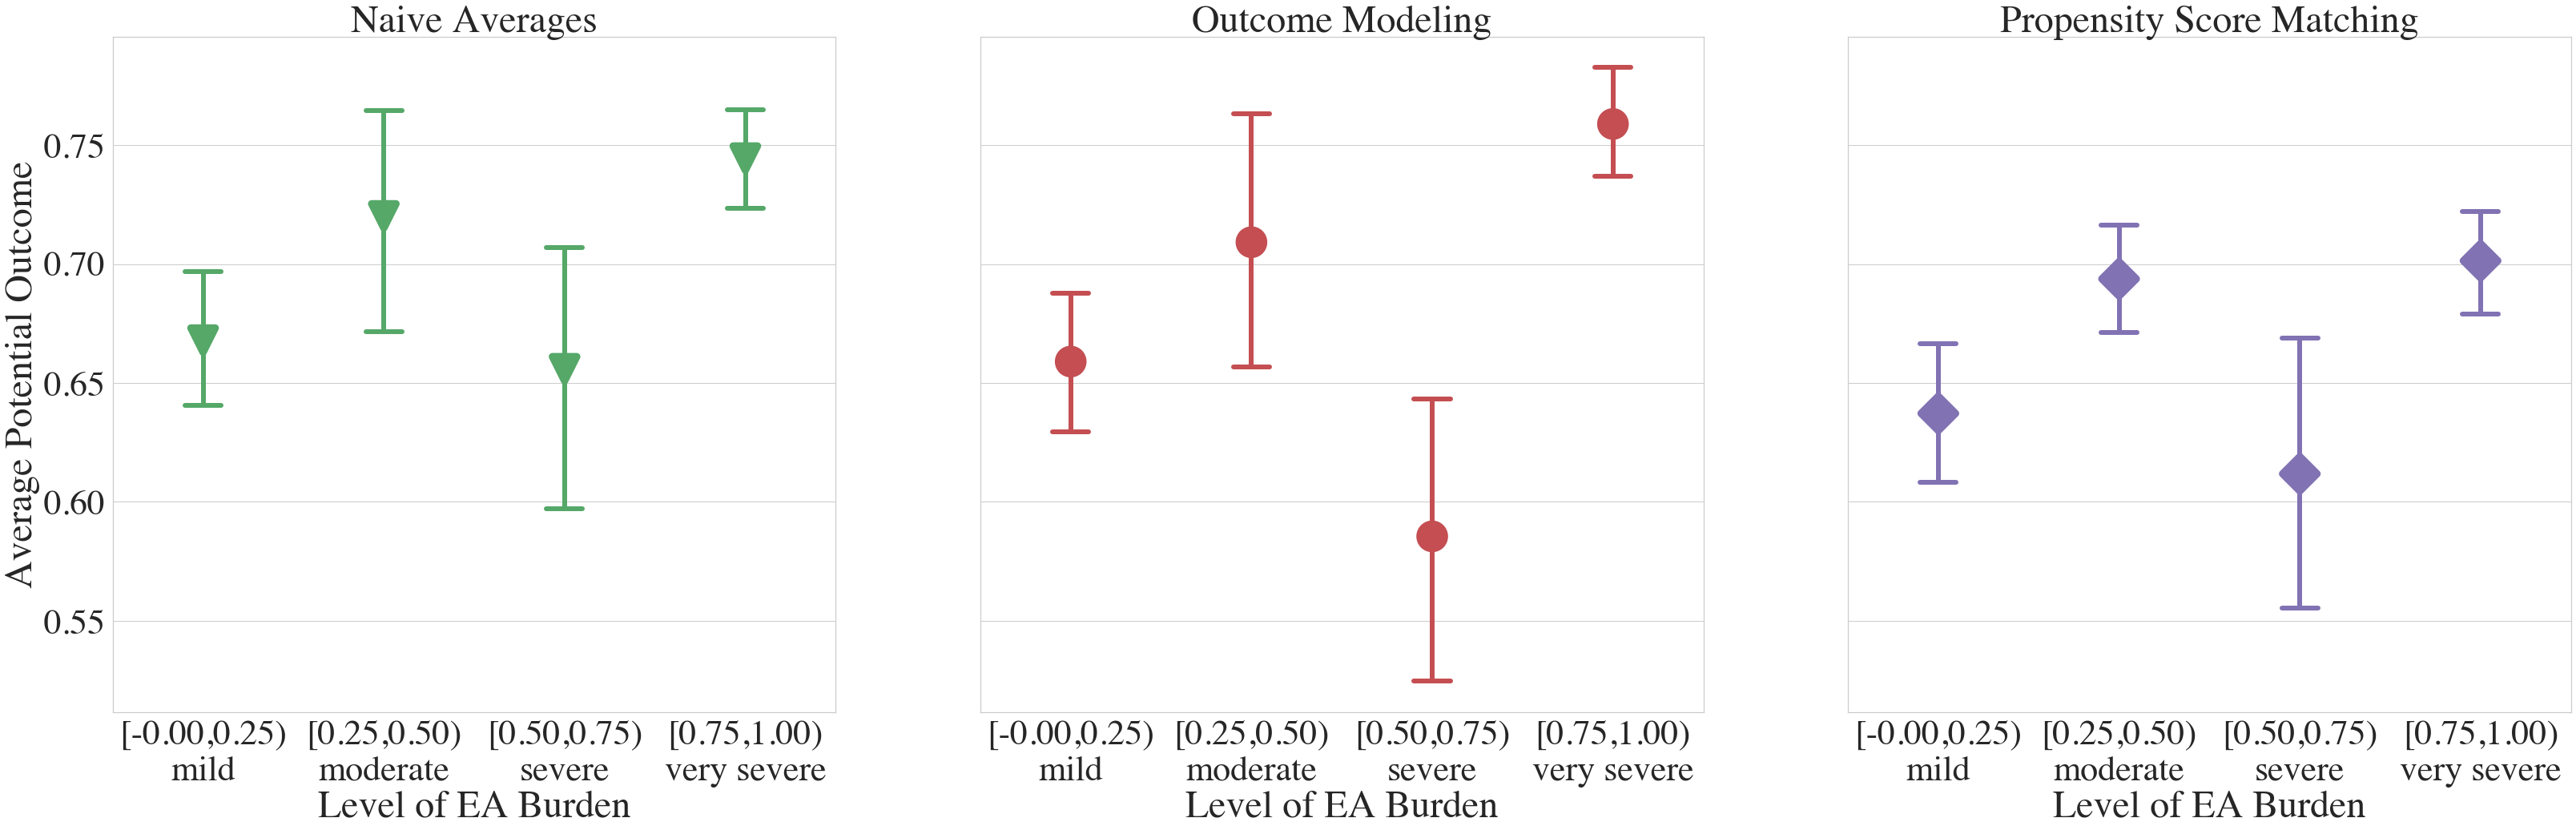

In [90]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

fig,ax = plt.subplots(figsize=(55,15.5),ncols=3,sharey=True,sharex=True)
sns.pointplot(data=est_naive.reset_index(),
             x='index',y=0,ax=ax[0],join=False,
             capsize=.2,markers=['v'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C2')
sns.pointplot(data=est_lr.reset_index(),
             x='index',y=0,ax=ax[1],join=False,
             capsize=.2,markers=['o'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C3')
sns.pointplot(data=est_prop.reset_index().rename(columns={0:'Average Potential Outcome'}),
             x='iic',y='Average Potential Outcome',ax=ax[2],join=False,
             capsize=.2,markers=['D'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C4')
ax[0].set_ylabel('Average Potential Outcome')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('Level of EA Burden')
ax[1].set_xlabel('Level of EA Burden')
ax[2].set_xlabel('Level of EA Burden')
ax[0].set_title('Naive Averages')
ax[1].set_title('Outcome Modeling')
ax[2].set_title('Propensity Score Matching')
level_eng = ['mild','moderate','severe','very severe']
plt.xticks(np.arange(len(thresholds)-1),['[%.2f,%.2f)\n%s'%(thresholds[i-1],thresholds[i],level_eng[i-1]) for i in range(1,len(thresholds)) ])
fig.savefig('max_reg.png')

In [88]:
 np.mean(lr_model.predict_proba(data_bootstrap.drop(columns=['Y']))[:,1])

0.8019095192714644

In [15]:
df_coarsen_2 = df_coarsen_1.copy(deep=True)
df_coarsen_2['levetiracetam'] = df_coarsen_2['levetiracetam'] > 20 
df_coarsen_2['propofol'] = df_coarsen_2['propofol'] > 1 
df_coarsen_2['midazolam'] = df_coarsen_2['midazolam'] > 0 
df_coarsen_2['lacosamide'] = df_coarsen_2['lacosamide'] > 0 
df_coarsen_2['phenobarbital'] = df_coarsen_2['phenobarbital'] > 0 
df_coarsen_2['valproate'] = df_coarsen_2['valproate'] > 0

df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].groupby(by=['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic']).count().rename({'0.12': '[0.0,0.25)', 
                                                                                                                        '0.38': '[0.25,0.50)', 
                                                                                                                        '0.62': '[0.50,0.75)', 
                                                                                                                        '0.88': '[0.75,1.00]'}, axis='index',level=6).to_csv('num_units_per_treatment_arm.csv')

In [39]:
df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].std(axis=0)

levetiracetam    0.498508
propofol         0.496539
midazolam        0.299479
lacosamide       0.265742
phenobarbital    0.153501
valproate        0.198866
Y                0.403923
dtype: float64

In [43]:
df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].corr().loc['Y'].abs()

levetiracetam    0.092473
propofol         0.158487
midazolam        0.077324
lacosamide       0.022664
phenobarbital    0.001288
valproate        0.032488
Y                1.000000
Name: Y, dtype: float64